# Applying the A360 Photometry Mask

Ben Levine\
LSST Science Piplines version: Weekly 2025_28\
Container Size: large

This notebook demonstrates how to apply the current version of the A360 photometry mask to a galaxy catalog.

Contributors to the hand mask were Ben Levine, Anja von der Linden, Rance Solomon, and Yuanyuan Zhang.

Contributors to the bright star mask were Nathan Amouroux and Rance Solomon.

Code for loading the data provided by "Shear profile around A360 using ComCam HSM shapes" by Combet, Englert, Fu, dell'Antonio, Adari.

In [1]:
# general python packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from lsst.daf.butler import Butler
import lsst.geom as geom
import lsst.afw.geom as afwGeom
from lsst.rsp import get_tap_service, retrieve_query

In [2]:
repo = '/repo/dp1'
collections = ['LSSTComCam/DP1']
butler = Butler(repo, collections=collections)
skymap = butler.get('skyMap', skymap='lsst_cells_v1')
service = get_tap_service("tap")
assert service is not None

Load the data within 0.7 degree from the BCG of Abell 360

In [3]:
# Position of the BCG for A360
ra_bcg = 37.862
dec_bcg = 6.98
range_deg = 0.7

query = "SELECT objectId, coord_ra, coord_dec, refExtendedness " \
        "FROM dp1.Object " \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), " \
        "CIRCLE('ICRS', %f, %f, %f)) = 1 "%(ra_bcg, dec_bcg, range_deg)

job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()

Job phase is COMPLETED


In [4]:
assert job.phase == 'COMPLETED'
merged_cat = job.fetch_result().to_table()
print(len(merged_cat))

345402


In [5]:
filt = merged_cat['refExtendedness'] > 0.5
merged_cat = merged_cat[filt]

In [6]:
print(len(merged_cat))

226282


# Apply healpix map

The map file contains four mask components (`bo`, `sfd`, `hand`, and `exp`), and their union (`full_mask`).

You can access each of these with dictionary-style indexing, e.g., `mask_hsp['full_mask']`.

In [7]:
import healsparse as hsp
mask_hsp = hsp.HealSparseMap.read('/home/b/bclevine/A360/A360_full_mask_hsp_128_131072.parquet')
print(mask_hsp.dtype.names)

('bo', 'sfd', 'hand', 'exp', 'full_mask')


In [8]:
mask = ~mask_hsp['full_mask'].get_values_pos(merged_cat['coord_ra'], merged_cat['coord_dec'], lonlat=True)
star_mask = ~mask_hsp['bo'].get_values_pos(merged_cat['coord_ra'], merged_cat['coord_dec'], lonlat=True)
dust_mask = ~mask_hsp['sfd'].get_values_pos(merged_cat['coord_ra'], merged_cat['coord_dec'], lonlat=True)
hand_mask = ~mask_hsp['hand'].get_values_pos(merged_cat['coord_ra'], merged_cat['coord_dec'], lonlat=True)
exp_mask = ~mask_hsp['exp'].get_values_pos(merged_cat['coord_ra'], merged_cat['coord_dec'], lonlat=True)

Text(0, 0.5, 'Dec')

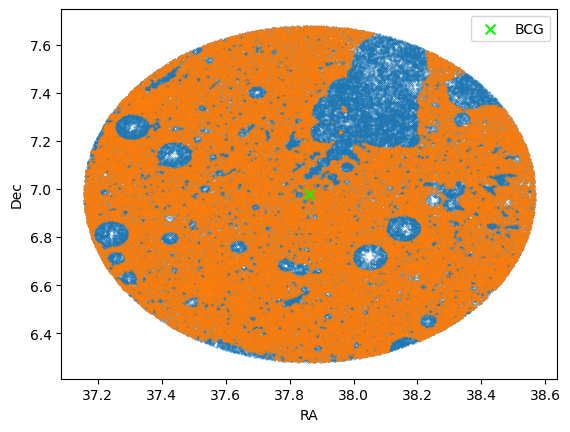

In [9]:
ra_bcg = 37.862
dec_bcg = 6.98
plt.scatter(merged_cat['coord_ra'], merged_cat['coord_dec'], marker='.', s=0.2)
plt.scatter(merged_cat['coord_ra'][mask], merged_cat['coord_dec'][mask], marker='.', s=0.2)

# Turn on/off the lines below to see the effects of individual components of the mask.
# plt.scatter(merged_cat['coord_ra'][star_mask], merged_cat['coord_dec'][star_mask], marker='.', s=0.2)
# plt.scatter(merged_cat['coord_ra'][hand_mask], merged_cat['coord_dec'][hand_mask], marker='.', s=0.2)
# plt.scatter(merged_cat['coord_ra'][dust_mask], merged_cat['coord_dec'][dust_mask], marker='.', s=0.2)
# plt.scatter(merged_cat['coord_ra'][exp_mask], merged_cat['coord_dec'][exp_mask], marker='.', s=0.2)

plt.scatter(ra_bcg, dec_bcg, marker='x', s=50, color='lime', label='BCG')
plt.legend()
plt.xlabel('RA')
plt.ylabel('Dec')

In [10]:
print(f'Objects kept: {np.count_nonzero(mask)}')
print(f'Proportion: {np.count_nonzero(mask)/len(merged_cat):.4f}')

Objects kept: 173448
Proportion: 0.7665
